### Описание задачи

Проанализировать и дать ответы на вопросы:

1. Что больше всего влияет на успешность продления подписки?
2. Какие есть проблемы у текущей модели?
3. Как лучше всего оценивать модель?
4. Построить модель для бинарной классификации - продлит пользователь подписку или нет

### Предварительный этап

In [ ]:
!pip install requierments.txt

### Разведывательный анализ данных

In [1]:
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import os
from tqdm import tqdm

from src.utils import download_dataset

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
data_path = 'data'
csv_fn = os.path.join(data_path, 'data_science_dataset_test_task.csv')

if not os.path.isfile(csv_fn):
    print('Dataset not found, downloading dataset...')
    os.mkdir(data_path)
    download_dataset(csv_fn)
    
print('Dataset path: ', csv_fn)

Dataset path:  data\data_science_dataset_test_task.csv


In [3]:
df = pd.read_csv(csv_fn)

print('Dataframe shape: ', df.shape)
df.head(5)

Dataframe shape:  (516180, 31)


,Unnamed: 0,current_dt,user_id,scheduled_dt,root_order_id,gender,age,os_family,lt_user,hours_after_reg_buy,...,was_3ds,card_type,card_country_code,success_orders,not_success_orders,insufficients,root_gross,not_root_gross,old_model_probability,is_success
0,37,2019-05-12 05:40:15.355095,13801584,2019-06-09 00:00:00.000000,96601292,f,43,11,2,0,...,0,2.0,154,2,0,0,29.17,6.81,0.512364,1
1,45,2019-06-07 08:10:15.982701,16144816,2019-06-09 00:00:00.000000,116843195,f,25,11,4,76,...,0,2.0,3,2,1,1,0.47,0.46,0.133615,1
2,46,2019-06-07 08:10:15.982701,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,1,0,...,0,2.0,1,2,1,0,0.48,6.67,0.481923,0
3,47,2019-06-08 03:10:13.314904,16467614,2019-06-09 00:00:00.000000,116847635,f,45,11,2,0,...,0,2.0,1,2,1,0,0.48,6.67,0.485032,0
4,51,2019-06-07 08:10:15.982701,16482460,2019-06-09 00:00:00.000000,116953235,m,45,11,1,0,...,0,2.0,1,1,1,1,0.48,0.00,0.114275,0


### Columns Description

Для начала посмотрим на признаки, их распределения, взаимосвязь с таргетом. Описание признаков, предоставленное вместе с данными:

| Column name             | Data type   | Description                                                           |
| ----------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| current\_dt             | timestamp   | в какой момент времени была собрана информация                                                                                                                                                         |
| user\_id                | id          | уникальный индефикатор пользователя                                                                                                                                                                    |
| scheduled\_dt           | timestamp   | дата на которую запланировано автопродление                                                                                                                                                            |
| root\_order\_id         | id          | уникальный индефикатор подписки                                                                                                                                                                        |
| gender                  | categorical | пол пользователя                                                                                                                                                                                       |
| age                     | categorical | возраст пользователя                                                                                                                                                                                   |
| os\_family              | categorical | операционная система пользователя                                                                                                                                                                      |
| lt\_user                | nominal     | lifetime пользователя                                                                                                                                                                                  |
| hours\_after\_reg\_buy  | nominal     | через сколько часов после регистрации пользователь оформил подписку                                                                                                                                    |
| country\_code           | categorical | страна пользователя                                                                                                                                                                                    |
| phone                   | categorical | марка телефона пользователя                                                                                                                                                                            |
| cpa                     | nominal     | СPA по которому был привлечен пользователь                                                                                                                                                             |
| retry\_number           | nominal     | номер попытки автопродлить подписку                                                                                                                                                                    |
| period                  | categorical | на какой период оформлена подписка                                                                                                                                                                     |
| gross                   | nominal     | сколько стоит продление подписки                                                                                                                                                                       |
| currency\_id            | categorical | валюта в какой оформлена подписка                                                                                                                                                                      |
| discount                | nominal     | размер скидки на продление                                                                                                                                                                             |
| psp                     | categorical | платежный шлюз                                                                                                                                                                                         |
| last\_response\_code    | categorical | при неудачных попытках автопродлить подписку платежный сервис отдает причину неудачи (response\_code). last\_response\_code говорит какой был ответ при прошлой попытке продлить подписку пользователю |
| bank                    | categorical | банк в котором оформлена карта пользователя                                                                                                                                                            |
| was\_3ds                | binary      | проходило ли оформление подписки через 3D Secure                                                                                                                                                       |
| card\_type              | categorical | тип карты                                                                                                                                                                                              |
| card\_country\_code     | categorical | страна оформления карты                                                                                                                                                                                |
| success\_orders         | nominal     | количество успешных оплат пользователя                                                                                                                                                                 |
| not\_success\_orders    | nominal     | количество не успешных оплат пользователя                                                                                                                                                              |
| insufficients           | nominal     | количество не успешных оплат пользователя по причине недостаточного количества средств на карте                                                                                                        |
| root\_gross             | nominal     | на какую сумму пользователь уже оформил данную подписку                                                                                                                                                |
| not\_root\_gross        | nominal     | какую сумму пользователь потратил без учета данной подписки                                                                                                                                            |
| old\_model\_probability |             | вероятность успешного продления данной подписки, которое отдает старая модель                                                                                                                          |
| is\_success             |             | результат - произошло ли продление подписки                                                                                                                                                            |


In [4]:
sample_size = round(df.shape[0] / df['Unnamed: 0'].max(), 2)
print(f'This df is {sample_size} part of initial dataset.')

This df is 0.2 part of initial dataset.


В датасете помимо вышеперечисленных 30 признаков есть также столбец `Unnamed: 0`, скорее всего этот столбец - индексы строк датасета из которого бралась эта подвыборка; он остался из за того что при сохранении данных в файл в функцию `to_csv()` не было передано значение параметра `index=False`. Данный столбец можно дропнуть. Кроме того, по данному столбцу можно предположить что предоставленная подвыборка является примерно пятой частью всего датасета.

In [5]:
profile = ProfileReport(df, title="Pandas Profiling Report", 
                        explorative=True, 
                        missing_diagrams={
                            "bar": False,
                            "matrix": False,
                            "heatmap": False,
                            "dendrogram": False,
                        },
                        correlations={
                            "pearson": {"calculate": True},
                            "spearman": {"calculate": True},
                            "kendall": {"calculate": False},
                            "phi_k": {"calculate": False},
                            "cramers": {"calculate": False},
                        }, 
                        interactions={"continuous": False,},
                        samples=None,
                       )

In [6]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/42 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Несколько моментов, которые стоит отметить:

#### Пропущенные значения

В датасете есть 58500 строк с пропущенными значениями. Пропуски присутствуют в трех таблицах: phone (15 записей), bank (33623 записи, 6.5%), card_type (24862 записи, 4.8%).

При обработке данных необходимо будет вставить пропущенные значения в датафрейм, так как многие алгоритмы машинного обучения не могут работать с пропущенными значениями. Если использовать модели основанные на деревьях решений, данный момент можно опустить.

В дальнейшем буду тестировать разные модели, поэтому заполню пропущенные значения, предлагаю попробовать несколько разных вариантов и посмотреть какой даст лучший результат:
1. Так как записей с пропущенным номером телефона немного, можно попробовать дропнуть эти строки
2. Вставим константные значения 0, среднего, медианы, моды (для категориальных)
3. Вставим значения вне диапазона (к примеру -1 для признака, значения которых лежат от 0 до +бесконечности) и создадим столбец, показывающий было ли значение пропущено.
4. Нормализуем данные и подберем пропущенные значения методом ближайших соседей.

#### Категориальные столбцы

Категориальные столбцы в последствии нужно закодировать можно использовать несколько способов:
1. Для категорий которые можно проранжировать можно использовать Ordinal Encoding (если есть категории low, medium, high они будут закодированы 0, 1, 2 соответственно)
2. Можно использовать OneHotEncoding, что создаст определенное количество бинарных столбцов (если брать пример выше, будут созданы 3 столбца category_low, category_medium, category_high, и для значения категории medium вектор будет 0, 1, 0; изначальный столбец category будет дропнут; в зависимости от реализации один из столбоцов с категориями может быть дропнут, к примеру если category_low и category_medium соответствуют значениям 0, 0 то можно однозначно сказать что category_high будет равен 1, и по сути нам не нужен этот столбец). Это расширяет пространство признаков, что может усложнить обучаемость некоторых моделей (к примеру SVM). Может возникать curse of dimensionality.
3. Можно закодировать категории чем то вроде TargetEncoding, который меняет категорию на частоту ее встречаемости в зависимости от таргета
4. Можно попробовать более экзотические вещи, например конвертировать все категориальные значения объекта в строку, затем смоделировать векторное представление используя LSA. Или использовать нечто вроде group2vec. Не уверен что такие способы зайдут конкретно для данной задачи и данных, но попробовать стоит. 

#### Распределение таргета

Таргет крайне не сбалансирован, первое что приходит на ум - нельзя использовать метрику вроде точности. Можно оценивать precision, recall, f1. Также можно попробовать использовать стратегии для несбалансированных выборок - undersampling, oversampling, комбинированные решения. 

### Время сбора информации

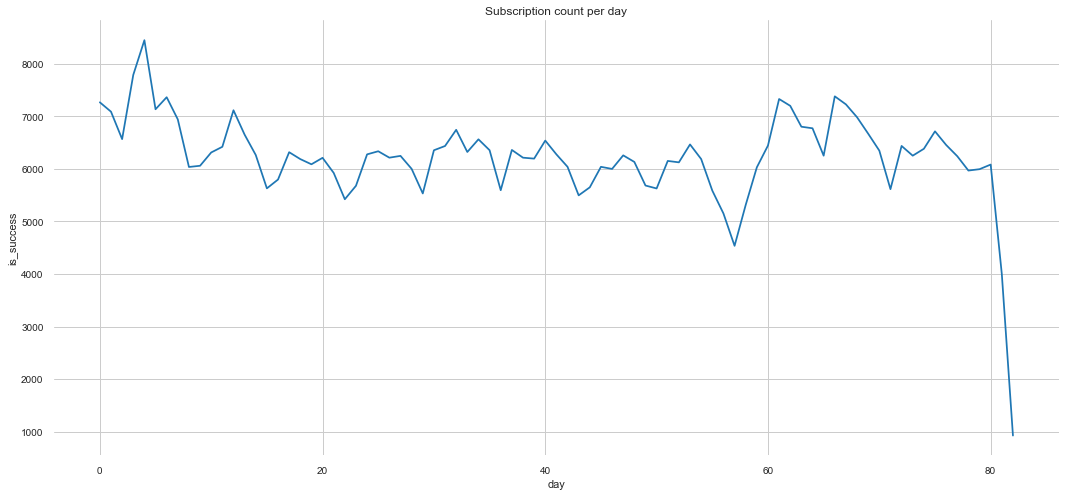

In [86]:
group = df.groupby('current_dt').agg({'is_success':'count'}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(18, 8))

sns.lineplot(x=np.arange(group.shape[0]), y=group.is_success, ax=ax)
ax.grid()
ax.set_title('Subscription count per day')
ax.set_xlabel('day')
plt.show()

In [92]:
for idx, date in zip(np.arange(group.shape[0]), sorted(df.current_dt.unique())):
    print(idx, ': ', date)

0 :  2019-04-04 09:29:44.187065
1 :  2019-04-05 14:29:34.064306
2 :  2019-04-06 12:37:33.675328
3 :  2019-04-07 12:37:14.022254
4 :  2019-04-08 12:37:15.359365
5 :  2019-04-09 12:37:18.809619
6 :  2019-04-10 15:25:25.430434
7 :  2019-04-11 15:25:33.022667
8 :  2019-04-12 16:27:56.055660
9 :  2019-04-13 15:25:13.725844
10 :  2019-04-14 15:25:19.364027
11 :  2019-04-15 08:49:55.138306
12 :  2019-04-16 07:49:30.751945
13 :  2019-04-18 12:52:27.706945
14 :  2019-04-19 12:52:29.854970
15 :  2019-04-20 12:52:09.053312
16 :  2019-04-21 09:52:25.682053
17 :  2019-04-22 09:52:17.675891
18 :  2019-04-23 09:52:20.571080
19 :  2019-04-24 09:52:20.196516
20 :  2019-04-25 07:52:06.718247
21 :  2019-04-26 10:20:17.618720
22 :  2019-04-27 12:20:35.792225
23 :  2019-04-28 09:20:26.688166
24 :  2019-04-29 12:40:33.962281
25 :  2019-04-30 09:40:25.052529
26 :  2019-05-01 07:40:26.315999
27 :  2019-05-02 09:40:39.662190
28 :  2019-05-03 07:40:26.960045
29 :  2019-05-04 09:40:11.206621
30 :  2019-05-05 07:

График зависимости количество подписок от дня получился зашумленный, возможно это связано с тем, что замеры производили не в одинаковое время (временной интервал замеров 12-13 часов, с минимумом в 3 часа ночи и максимумом в 15-16). Также по какой то причине 2019-04-17 не зафиксировали данные.

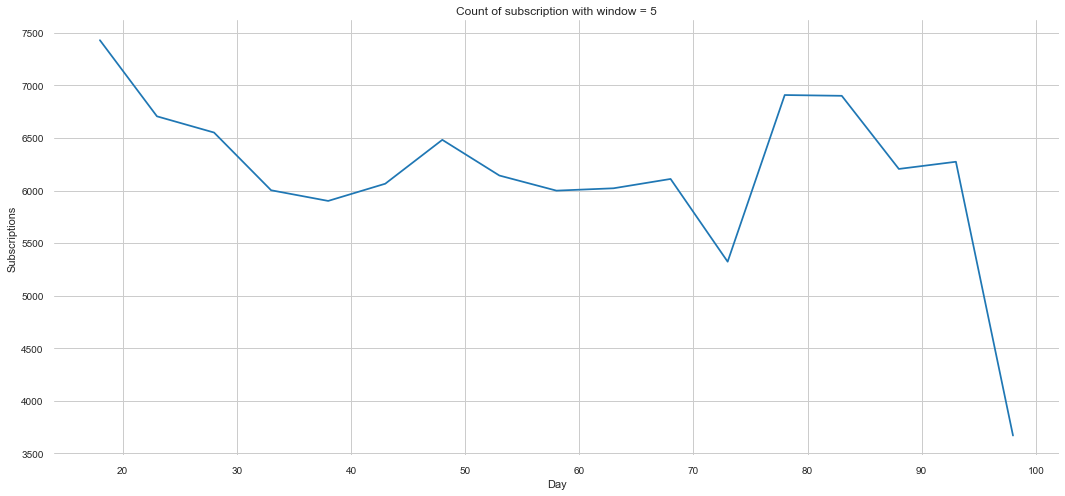

In [100]:
is_success = df.groupby('current_dt').agg({'is_success': 'count'}).values

window_size = 5

success_data = []
for i in range(0, len(is_success), window_size):
    success_data.append(np.mean(is_success[i:i+window_size]))
    
x = np.arange(len(success_data)) * window_size + 18

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(x, success_data)
ax.set_title(f'Count of subscription with window = {window_size}')
ax.set_xlabel('Day')
ax.set_ylabel('Subscriptions')
ax.grid()
plt.show()

### Категориальные признаки 

Посмотрим на пропорции категорий, процент успешных подписок в зависимости от категорий.

Plotting insufficients: : 19it [00:03,  5.00it/s]     


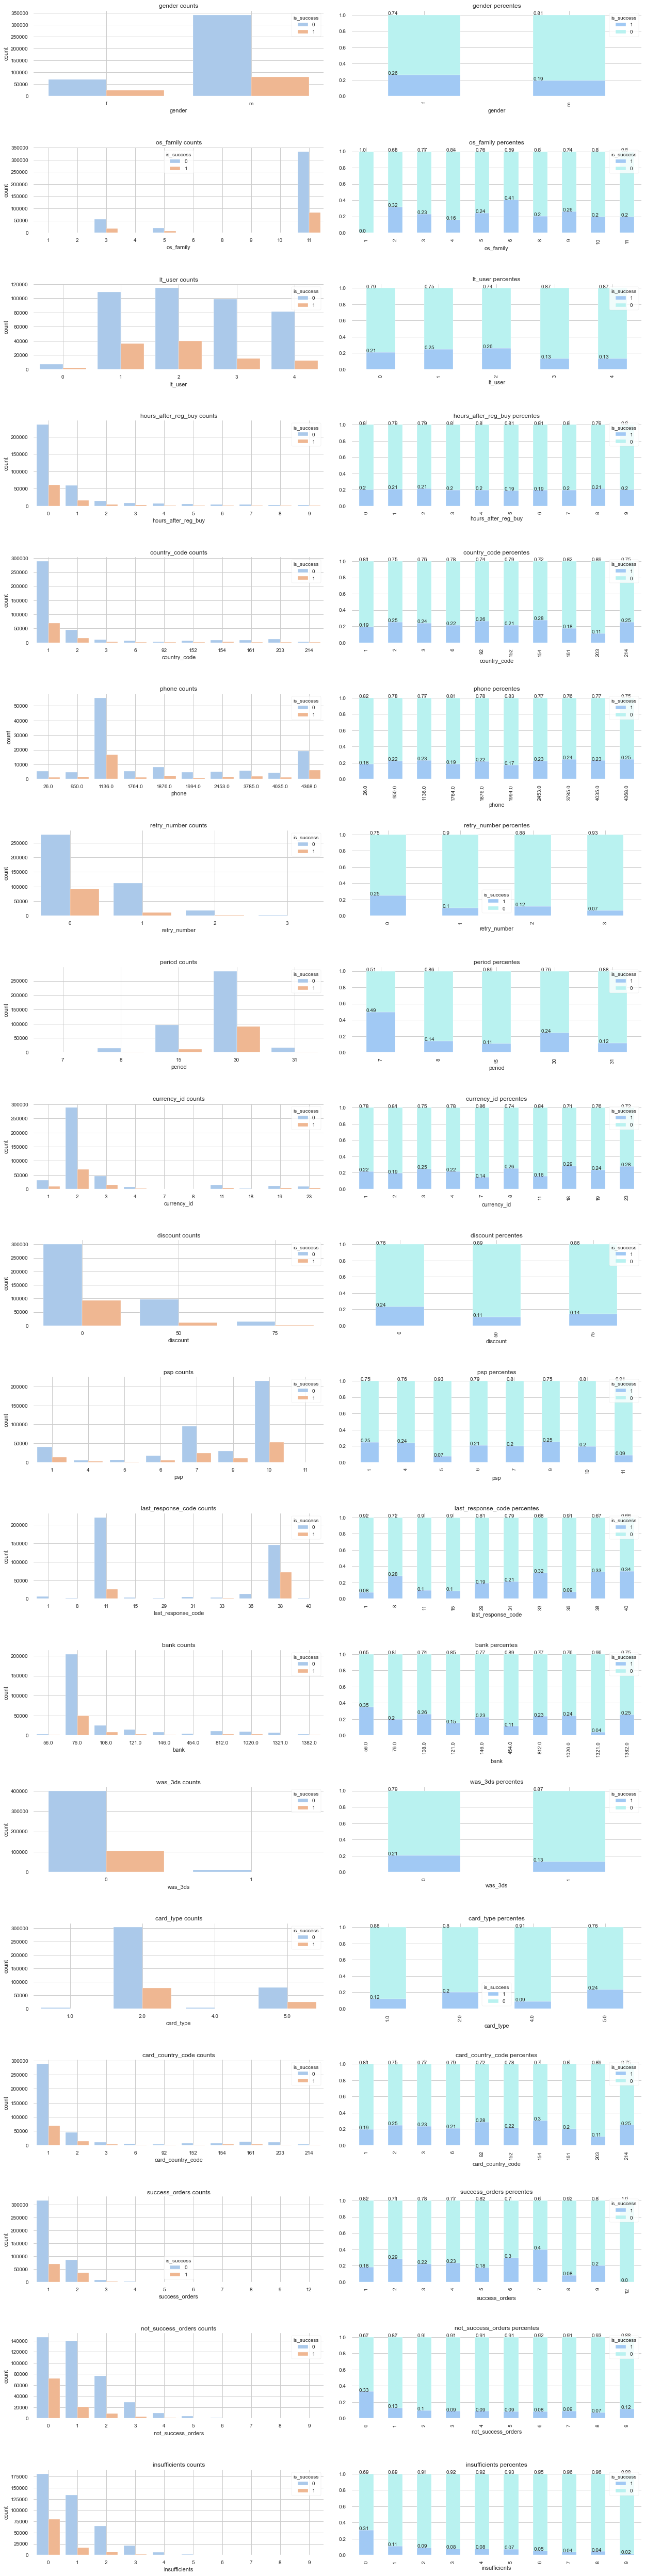

In [103]:
df_to_plot = df.drop(['Unnamed: 0', 'current_dt', 'scheduled_dt',
                      'gross', 'cpa', 'root_order_id', 'age', 
                      'old_model_probability', 'root_gross', 'not_root_gross'],
                     axis=1)
cols = df_to_plot.columns[1:-1]

fig, axs = plt.subplots(len(cols), 2, figsize=(18,70))

pbar = tqdm(zip(cols, axs))
for col, ax in pbar:
    pbar.set_description("Plotting %s" % col)
    
    most_freq = df_to_plot[col].value_counts().iloc[:10].index
    subset = df_to_plot[df_to_plot[col].isin(most_freq)]
    
    sns.countplot(data=subset, x=col, hue='is_success', palette="pastel", ax=ax[0])
    
    counts_df = subset.groupby([col, 'is_success'])['user_id'].count().unstack()
    percentes = counts_df.T.div(counts_df.T.sum()).T
    percentes = percentes[percentes.columns[::-1]]
    percentes.plot(kind="bar",
                   stacked=True,
                   ax=ax[1],
                   colormap=ListedColormap(sns.color_palette("pastel", 10)))
    
    ax[0].set_title(f'{col} counts')
    ax[0].grid()
    
    for idx, p in enumerate(ax[1].patches):
        x, y = p.get_x() * 1.005, p.get_height() * 1.005
        if idx >= len(ax[1].patches) / 2:
            y = 1
        ax[1].annotate(str(round(p.get_height(), 2)), (x, y))
    
    
    ax[1].set_title(f'{col} percentes')
    ax[1].grid()
    
plt.tight_layout(pad=3.0)
plt.show()

### Численные признаки

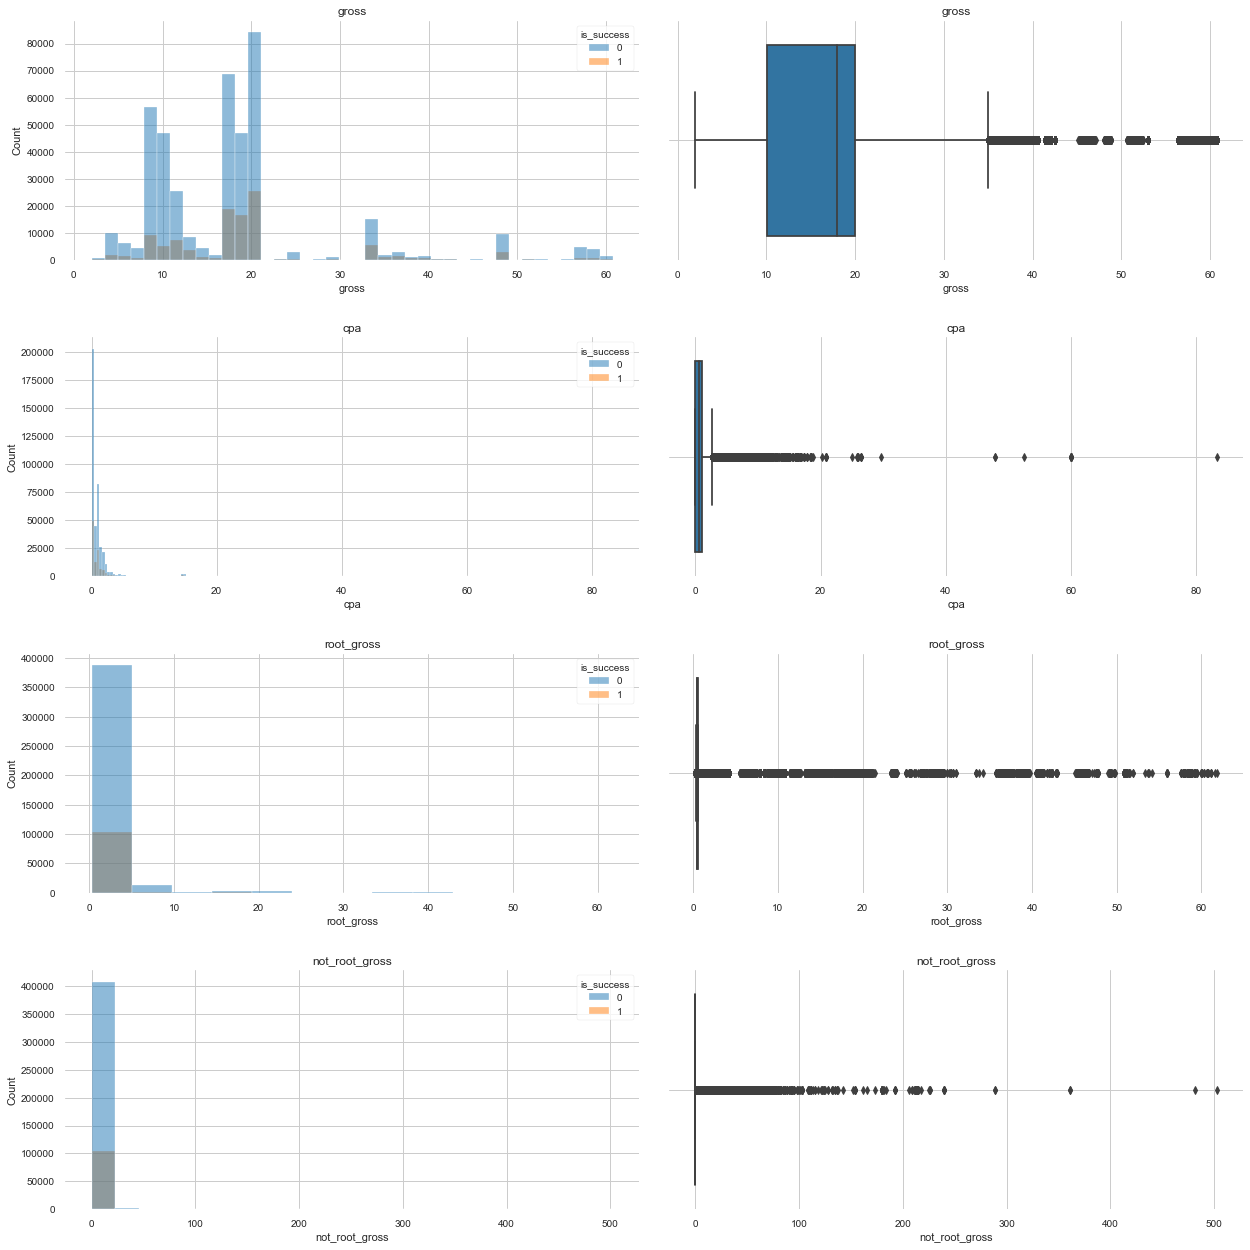

In [70]:
cols = ['gross', 'cpa', 'root_gross', 'not_root_gross', 'is_success']

fig, axs = plt.subplots(len(cols[:-1]), 2, figsize=(18, 18))

for col, ax in zip(cols[:-1], axs):
    sns.histplot(data=df, x=col, hue='is_success', ax=ax[0], bins=int(df[col].nunique()/100))
    sns.boxplot(data=df, x=col, ax=ax[1])
    ax[0].set_title(col)
    ax[1].set_title(col)
    
    ax[0].grid()
    ax[1].grid()

plt.tight_layout(pad=3.0)
plt.show()

### Возраст

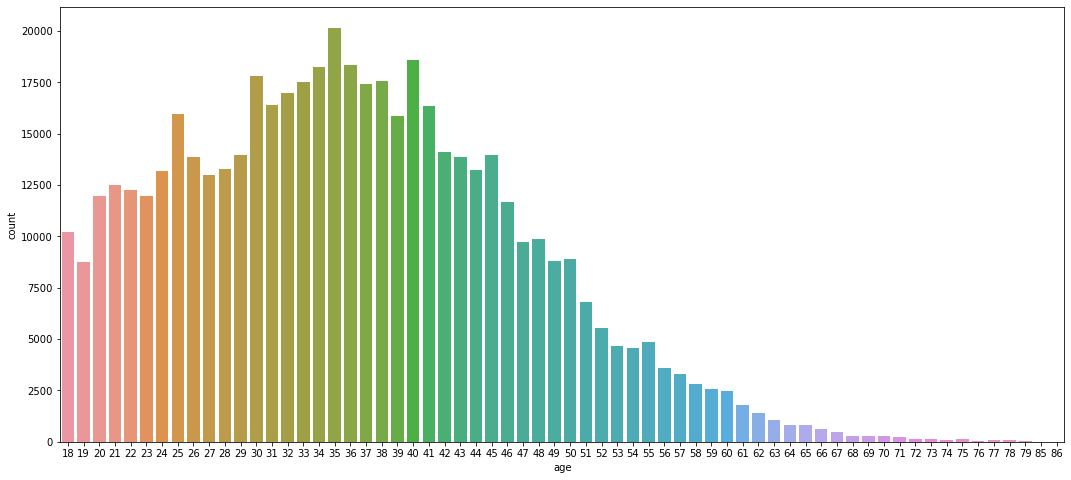

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df, x='age', ax=ax)
plt.show()

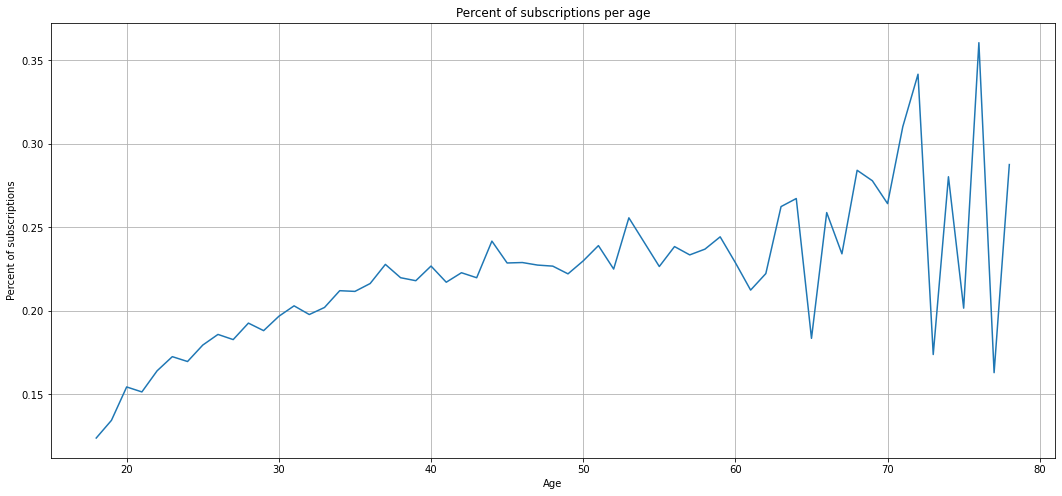

In [15]:
number_of_peoples_tr = 30
sub_per_age = df.groupby('age').agg({'is_success': 'mean', 'user_id': 'count'}).reset_index()
sub_per_age = sub_per_age[sub_per_age['user_id'] > number_of_peoples_tr]

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(sub_per_age.age, sub_per_age.is_success)
ax.set_title('Percent of subscriptions per age')
ax.set_xlabel('Age')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
plt.show()

На графике выше представлен процент пользователей купивших подписку в зависимости от возраста. Так как количество пользователей в возрасте 60 лет и старше относительно мало, график в правой части становится слишком шумным. Чтобы хоть как то это пофиксить, выбирал только возраста с количеством пользователей больше определенного порога. В целом можно сказать что пользователи постарше более склонны продлить подписку. 

### Возраст и пол

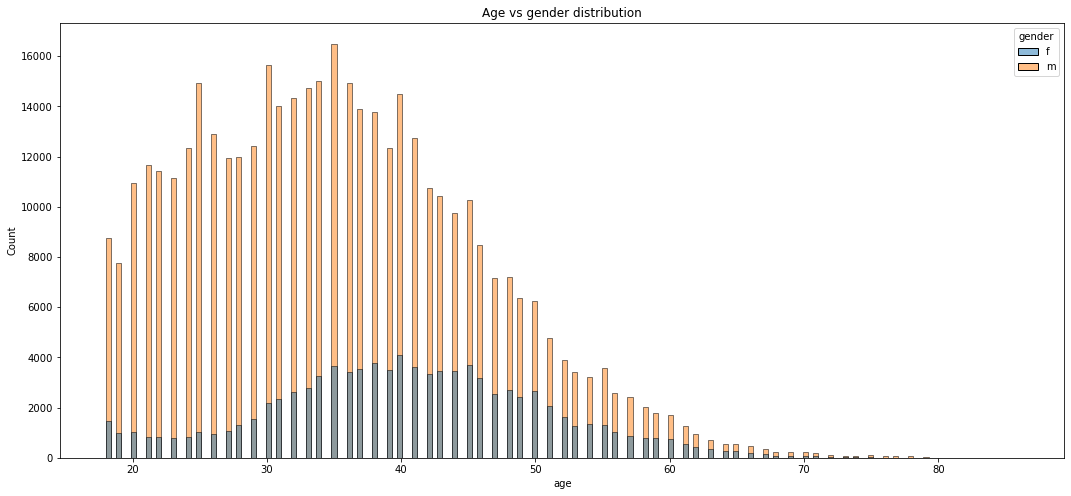

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.histplot(data=df, x='age', hue='gender', ax=ax)
ax.set_title('Age vs gender distribution')
plt.show()

In [17]:
age_gender = df.groupby(['gender']).agg({'age':['mean', 'median', 'min', 'max']}).reset_index()
age_gender

gender        age               
               mean median min max
0      f  40.354889     40  18  79
1      m  35.214534     34  18  86

Средний возраст мужской аудитории меньше чем женской на 5-6 лет.

### Возраст vs пол vs подписка

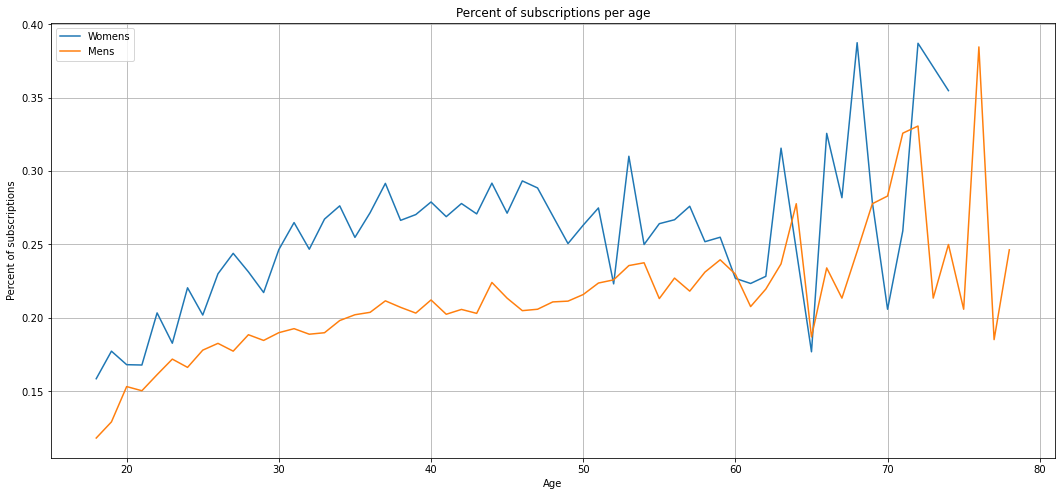

In [18]:
number_of_peoples_tr = 30
sub_per_age = df.groupby(['age', 'gender']).agg({'is_success': 'mean', 'user_id': 'count'}).reset_index()

womens = sub_per_age[sub_per_age['gender'] == 'f']
mens = sub_per_age[sub_per_age['gender'] == 'm']

womens = womens[womens['user_id'] > number_of_peoples_tr]
mens = mens[mens['user_id'] > number_of_peoples_tr]

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(womens.age, womens.is_success, label='Womens')
ax.plot(mens.age, mens.is_success, label='Mens')
ax.set_title('Percent of subscriptions per age')
ax.set_xlabel('Age')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
ax.legend()
plt.show()

Интересно заметить, что в то время когда процент подписок у мужчин растет более-менее равномерно в зависимости от возраста, у женщин после 40-45 идет небольшая просадка. Более явно увидеть этот тренд можно, если использовать скользящее среднее.

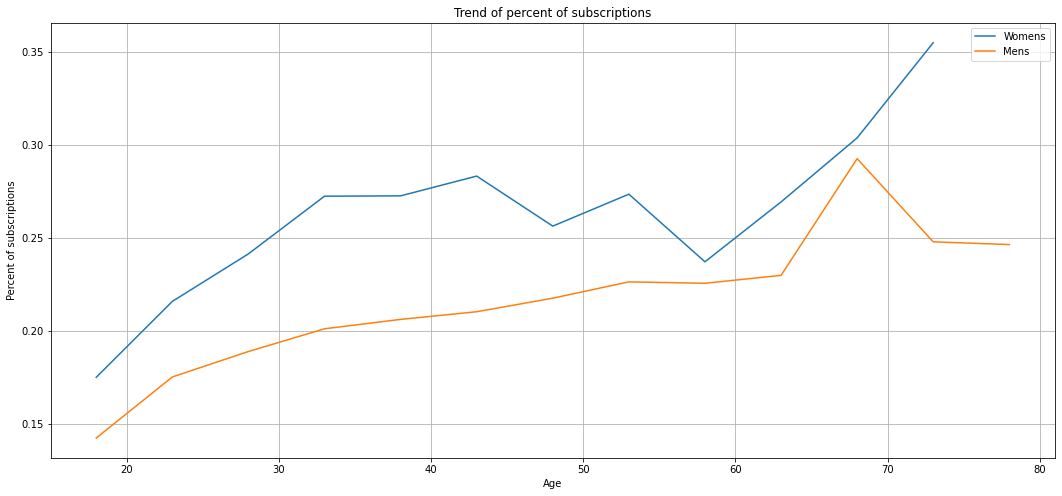

In [19]:
wmn_success_rate = womens.is_success.values
men_success_rate = mens.is_success.values

window_size = 5

wmn_window_data = []
for i in range(0, len(wmn_success_rate), window_size):
    wmn_window_data.append(np.mean(wmn_success_rate[i:i+window_size]))
    
men_window_data = []
for i in range(0, len(men_success_rate), window_size):
    men_window_data.append(np.mean(men_success_rate[i:i+window_size]))
    
wmn_x = np.arange(len(wmn_window_data)) * window_size + 18
men_x = np.arange(len(men_window_data)) * window_size + 18

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(wmn_x, wmn_window_data, label='Womens')
ax.plot(men_x, men_window_data, label='Mens')
ax.set_title('Trend of percent of subscriptions')
ax.set_xlabel('Age')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
ax.legend()
plt.show()

### user_id

In [102]:
df.groupby('user_id').agg({'is_success': ['sum', 'mean']})

is_success     
                sum mean
user_id                 
9446267           0  0.0
9446429           0  0.0
9446508           0  0.0
9446541           0  0.0
9446570           1  0.5
...             ...  ...
18090231          0  0.0
18090244          0  0.0
18090311          0  0.0
18090461          0  0.0
18090490          2  1.0

[185138 rows x 2 columns]

### hours_after_reg_buy

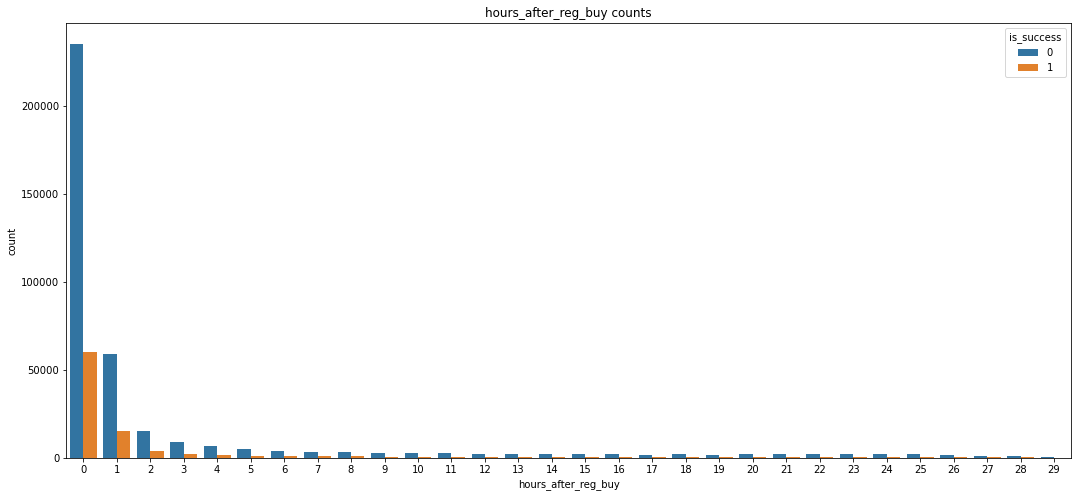

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
sns.countplot(data=df[df['hours_after_reg_buy'] < 30], x='hours_after_reg_buy', hue='is_success', ax=ax)
ax.set_title('hours_after_reg_buy counts')
plt.show()

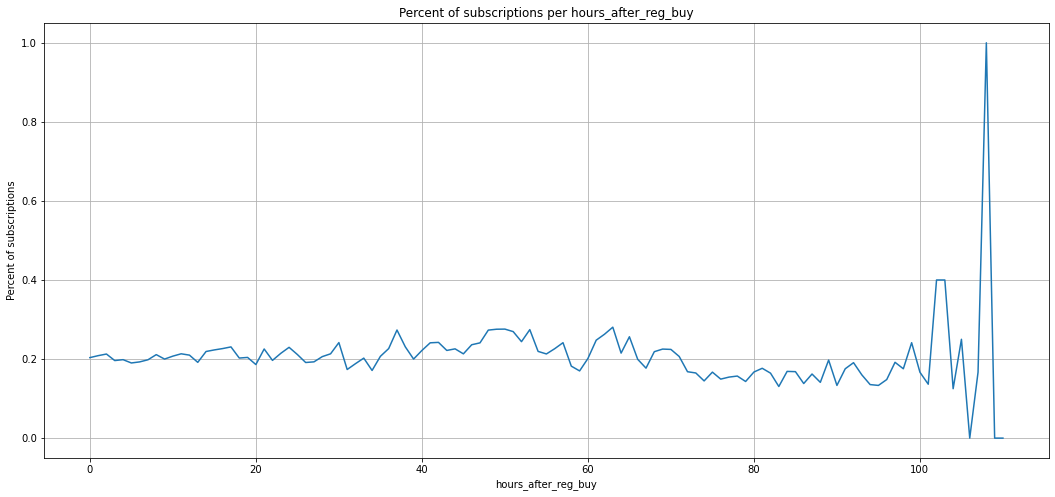

In [26]:
group = df.groupby('hours_after_reg_buy').agg({'is_success': 'mean'}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(group.hours_after_reg_buy, group.is_success)
ax.set_title('Percent of subscriptions per hours_after_reg_buy')
ax.set_xlabel('hours_after_reg_buy')
ax.set_ylabel('Percent of subscriptions')
ax.grid()
plt.show()

### Анализ результатов предыдущей модели

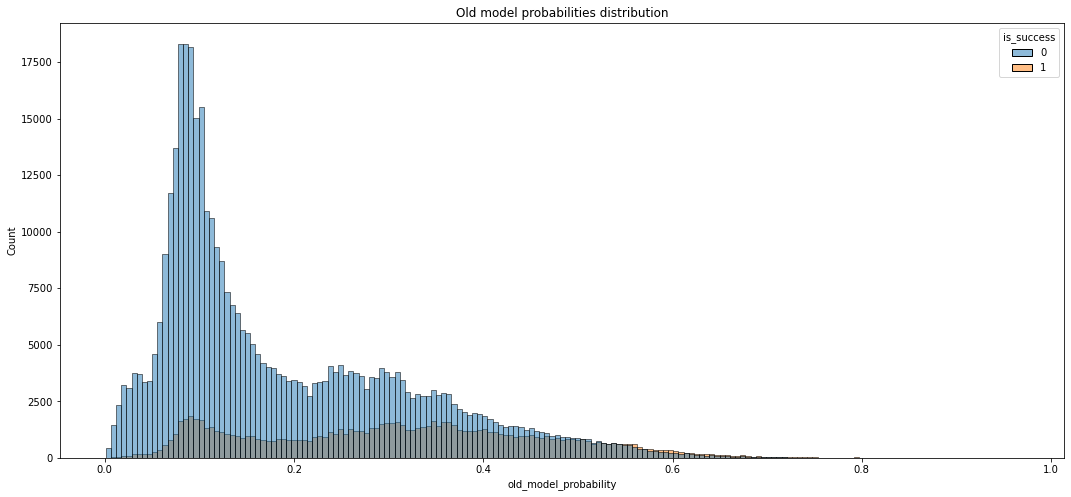

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
sns.histplot(data=df, x='old_model_probability', ax=ax, hue='is_success')
ax.set_title('Old model probabilities distribution')
plt.show()

Плотность вероятности того что пользователь продлит подписку, предсказанная предыдущей моделью, сосредоточена в диапазоне от 0 до 0.6, что может говорить о нерепрезентативных признаках, на которых обучали модель. У модели, обученной на сбалансированной выборке и репрезентативных признаках, в задаче бинарной классификации распределение вероятностей должно быть бимодальным, с модами ближе к 0 и 1.

In [106]:
threshold = 0.2
old_model_probability = df.old_model_probability.values

targets = df.is_success.values
old_model_predictions = np.array(old_model_probability > threshold, dtype='int8')

precision = precision_score(targets, old_model_predictions)
recall = recall_score(targets, old_model_predictions)
f1 = f1_score(targets, old_model_predictions)
roc_auc = roc_auc_score(targets, old_model_predictions)

print('Old model precision: ', precision)
print('Old model recall: ', recall)
print('Old model f1: ', f1)
print('Old model roc_auc: ', roc_auc)

Old model precision:  0.3388674206584311
Old model recall:  0.7232109156790216
Old model f1:  0.46149631190727086
Old model roc_auc:  0.6793412673391743


При пороге 0.5, если считать что старая модель предсказывает 1 при вероятности больше порога, получаются весьма посредственные значения метрик. Грубо говоря, каждый второй предикт, показывающий что пользователь продлит подписку, ошибочен (precision).

C:\Users\sqrte\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


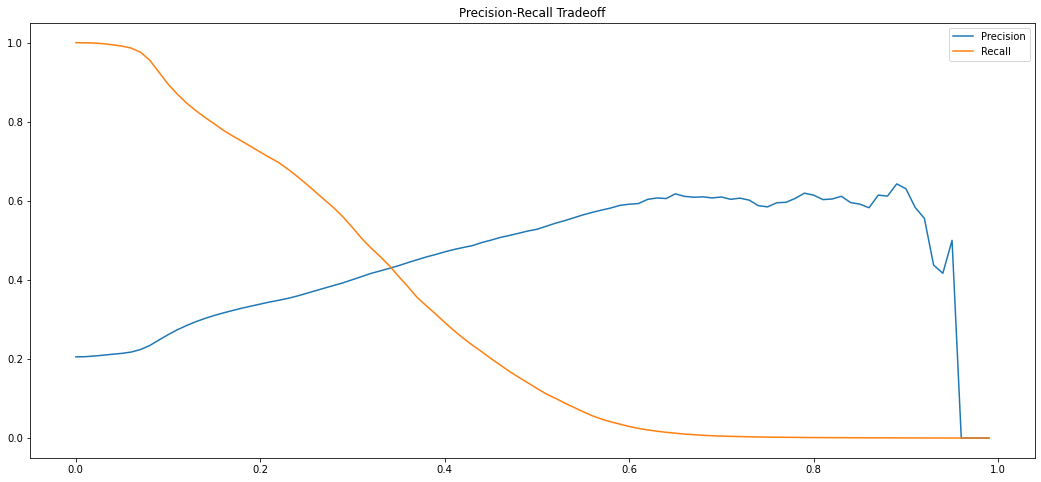

In [9]:
precisions = []
recalls = []

x = np.arange(0, 1, 0.01)
for threshold in x:
    old_model_predictions = np.array(old_model_probability > threshold, dtype='int8')
    precision = precision_score(targets, old_model_predictions)
    recall = recall_score(targets, old_model_predictions)
    
    precisions.append(precision)
    recalls.append(recall)
    
fig, ax = plt.subplots(1, 1, figsize=(18,8))
ax.set_title('Precision-Recall Tradeoff')
ax.plot(x, precisions, label='Precision')
ax.plot(x, recalls, label='Recall')
ax.legend()
plt.show()

Модель не предсказывала вероятности, которые были бы выше 0.96, в связи с эти график precision-а выглядит весьма странно.

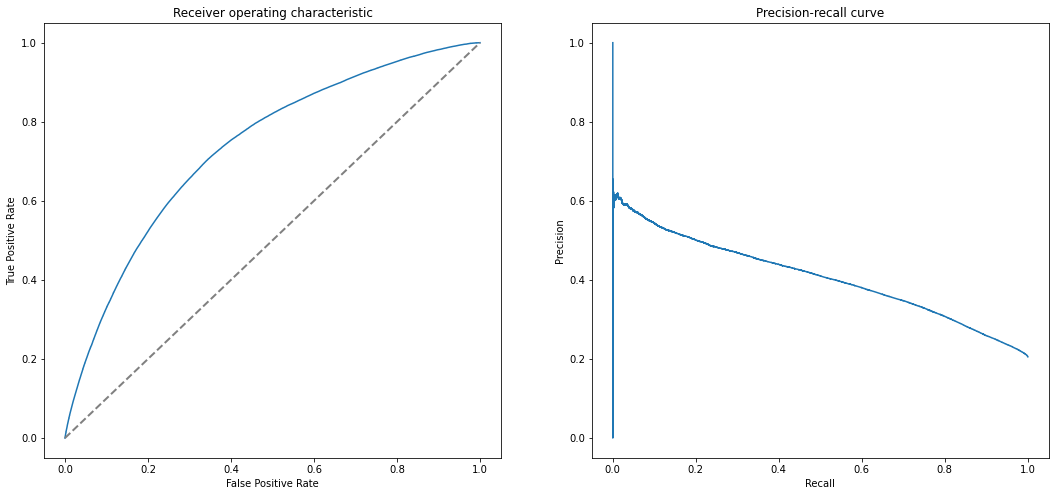

In [11]:
fpr, tpr, _ = roc_curve(targets, old_model_probability)
precision, recall, _ = precision_recall_curve(targets, old_model_probability)

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

lw = 2
axs[0].plot(fpr, tpr)
axs[0].plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
axs[0].set_title('Receiver operating characteristic')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')

axs[1].plot(recall, precision)
axs[1].set_title('Precision-recall curve')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
plt.show()